In [1]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm

from sklearn.preprocessing import PolynomialFeatures
from utils.numerical_differentiation.tikhonov import TikhonovDifferentiation

from scipy.linalg import lstsq
from scipy.integrate import odeint
from scipy.sparse import tril, eye, coo_matrix
from scipy import interpolate
from csaps import csaps

import pandas as pd

import matplotlib.pyplot as plt
from derivative import dxdt

# Install R packages to run on Python
# import rpy2's package module
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr

In [2]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def vanderpol(x, t, gamma=1, kappa=1, epsilon=2):
    return [
            x[1],
            -kappa * x[0] - gamma * x[1] - epsilon * x[1] * x[0] ** 2
            ]

gamma=1
kappa=1
epsilon=2

#Finite difference matrix of any order
def diff_mat(n,order):
    #Zero'th derivative
    if order==0:
        D = eye(n)
    else:
        #Compute D of specific order
        c = np.array([-1,1] + [0] * (order-1))

        nd = n-order
        for i in range(1,order):
            c = np.append(0,c[0:order]) - np.append(c[0:order],0)

        D = coo_matrix((nd, n), dtype=np.int8)

        for i in range(0,order+1):
            row = np.array(range(nd))
            col = np.array(range(nd)) + i
            val = c[i] * np.ones(nd)
            D = D + coo_matrix((val, (row, col)), shape=(nd, n))

    return D

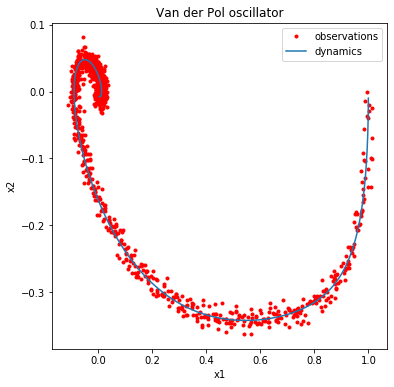

In [3]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [1, 0]
X = odeint(vanderpol, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -kappa * x1 - gamma * x2 - epsilon * x2 * x1 ** 2

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.01
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Van der Pol oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

## Trend filtering algorithm

$\hat{\beta} = \text{argmin} \frac{1}{2} ||y - \beta||_2^2 + \lambda ||D^{(k+1)}\beta||_1$

In [4]:
# TREND FILTERING ALGORITHM
matrix = importr('Matrix')
genlasso = importr('genlasso')

y_trendfilter = []
dy_trendfilter = []
error_trendfilter = []
residual_trendfilter = []
reg_residual_trendfilter = []
lambdas_trendfilter = []
gcv_trendfilter = []

#Generate difference matrix
D3 = diff_mat(m_samples,3)

#Loop over all state variables
for state in range(n_states):

    # Transform into R vectors
    r_y = robjects.FloatVector(Y[:,state])
    r_t = robjects.FloatVector(t)

    #Create trendfilter object with specific inputs
    trendfilter = genlasso.trendfilter(y = r_y, ord = 3, maxsteps = 10000, minlam = 0)
    
    #Evaluate fitted data to specific grid r1_t ( Need to convert into np.array )
#     lamb_lasso_path = np.array(robjects.r['predict'](trendfilter).rx2('lambda'))
    lamb_lasso_path = np.array(trendfilter.rx2('lambda'))
    df = np.array(trendfilter.rx2('df'))
    lambdas_trendfilter.append(lamb_lasso_path)

    n_lambdas = len(lamb_lasso_path)
    reg_residual = np.zeros(n_lambdas)
    residual = np.zeros(n_lambdas)
    gcv = np.zeros(n_lambdas)
    
    y_tf = np.array(robjects.r['predict'](trendfilter).rx2('fit'))
    y_trendfilter.append(y_tf)#Append an array to a list for each state
    
    #Compute derivatives via splines for all lambdas
    dy_tf = np.zeros((m_samples,n_lambdas))
    error_dy_tf = np.zeros(n_lambdas)

    for i, reg_lambda in enumerate(lamb_lasso_path):
        y_tf_ss = interpolate.splrep(t, y_tf[:,i], k=3, s=0)
        dy_tf[:,i] = interpolate.splev(t, y_tf_ss, der=1)
        
        error_dy_tf[i] = norm(dy_tf[:,i] - dX[:,state])/norm(dX[:,state])
        residual[i] = np.sum((r_y - y_tf[:,i]) ** 2)
        reg_residual[i] = norm(D3 * y_tf[:,i], ord = 1)
        gcv[i] = 1/m_samples * np.sum(((r_y - y_tf[:,i])/(1 - df[i]/m_samples)) ** 2)
        
    dy_trendfilter.append(dy_tf)
    error_trendfilter.append(error_dy_tf)
    residual_trendfilter.append(residual)
    reg_residual_trendfilter.append(reg_residual)
    gcv_trendfilter.append(gcv)

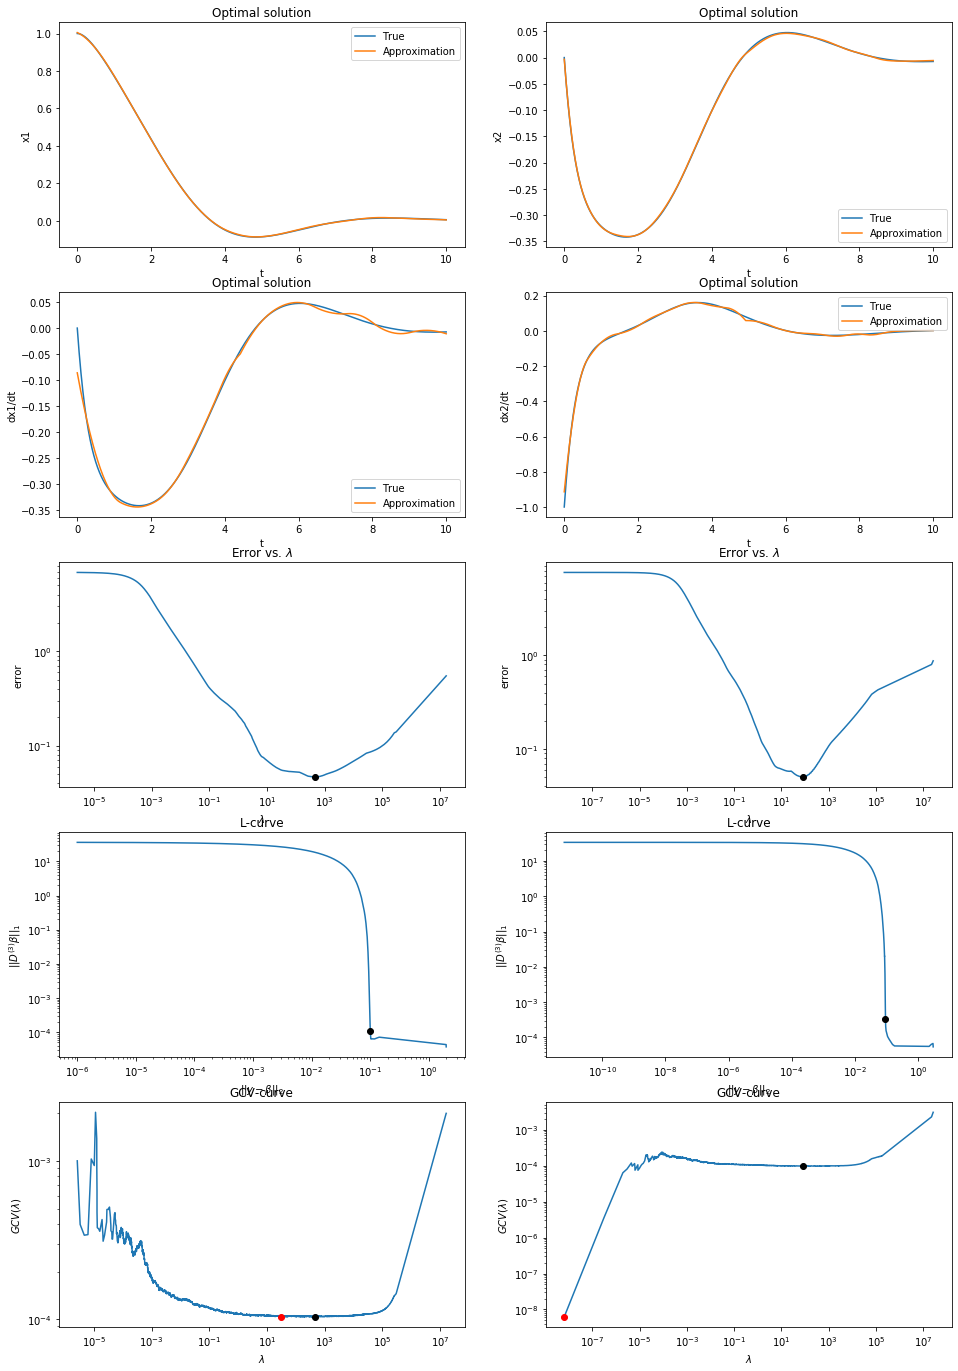

In [5]:
# Compute the lambda that yields the minimum error

fig,axs = plt.subplots(5,n_states,figsize = (16,24))
plt.tight_layout

for state in range(n_states):
    
    lambda_min_indx = np.argmin(error_trendfilter[state])
    lambda_min_gcv_indx = np.argmin(gcv_trendfilter[state])
    
    axs[0,state].plot(t,X[:,state])
    axs[0,state].plot(t,y_trendfilter[state][:,lambda_min_indx])
    axs[0,state].set_title('Optimal solution')
    axs[0,state].set_xlabel('t')
    axs[0,state].set_ylabel(f'x{state+1}')
    axs[0,state].legend(['True','Approximation'])
    
    axs[1,state].plot(t,dX[:,state])
    axs[1,state].plot(t,dy_trendfilter[state][:,lambda_min_indx])
    axs[1,state].set_title('Optimal solution')
    axs[1,state].set_xlabel('t')
    axs[1,state].set_ylabel(f'dx{state+1}/dt')
    axs[1,state].legend(['True','Approximation'])
    
    axs[2,state].loglog(lambdas_trendfilter[state],error_trendfilter[state])
    axs[2,state].loglog(lambdas_trendfilter[state][lambda_min_indx],error_trendfilter[state][lambda_min_indx],'ko')
    axs[2,state].set_title('Error vs. $\lambda$')
    axs[2,state].set_xlabel('$\lambda$')
    axs[2,state].set_ylabel('error')
    
    axs[3,state].loglog(residual_trendfilter[state],reg_residual_trendfilter[state])
    axs[3,state].loglog(residual_trendfilter[state][lambda_min_indx],reg_residual_trendfilter[state][lambda_min_indx],'ko')
    axs[3,state].set_title('L-curve')
    axs[3,state].set_xlabel(r'$||y - \beta||_2$')
    axs[3,state].set_ylabel(r'$||D^{(3)}\beta||_1$')   
    
    axs[4,state].loglog(lambdas_trendfilter[state],gcv_trendfilter[state])
    axs[4,state].loglog(lambdas_trendfilter[state][lambda_min_indx],gcv_trendfilter[state][lambda_min_indx],'ko')
    axs[4,state].loglog(lambdas_trendfilter[state][lambda_min_gcv_indx],gcv_trendfilter[state][lambda_min_gcv_indx],'ro')
    axs[4,state].set_title('GCV-curve')
    axs[4,state].set_xlabel(r'$\lambda$')
    axs[4,state].set_ylabel(r'$GCV(\lambda)$')